# Pre-processing

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [19]:
# variables names
features = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classification","difficulty"]

train = pd.read_csv('C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\KDDTrain+.txt', header=None, names=features)#train dataset
test = pd.read_csv('C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\KDDTest+.txt', header=None, names=features, quotechar='"')#test dataest
train.drop("difficulty", axis=1, inplace=True)
test.drop("difficulty", axis=1, inplace=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Replacing all the different attack names with their attack type
# #train dataset
train.loc[(train['classification'] =='smurf')|(train['classification'] =='neptune') | (train['classification'] =='back') | (train['classification'] =='teardrop') |(train['classification'] =='pod')| (train['classification']=='land'),'classification'] = 'Dos'
train.loc[(train['classification'] =='satan')|(train['classification'] =='ipsweep') | (train['classification'] =='portsweep') | (train['classification'] =='nmap'),'classification'] = 'probe'
train.loc[(train['classification'] =='spy')|(train['classification'] =='phf')|(train['classification'] =='multihop')|(train['classification'] =='ftp_write') | (train['classification'] =='imap') | (train['classification'] =='warezmaster') |(train['classification'] =='guess_passwd')| (train['classification']=='warezclient'),'classification'] = 'r2l'
train.loc[(train['classification'] =='buffer_overflow')|(train['classification'] =='rootkit') | (train['classification'] =='loadmodule') | (train['classification'] =='perl'),'classification']='u2r'
train.loc[(train['classification'] =='normal'),'classification'] = 'normal'

#test dataset
test.loc[(test['classification'] =='smurf')|(test['classification'] =='neptune') | (test['classification'] =='back') | (test['classification'] =='teardrop') |(test['classification'] =='pod')| (test['classification']=='land')|(test['classification']=='apache2')|(test['classification']=='udpstorm')|(test['classification']=='processtable')|(test['classification']=='mailbomb'),'classification'] = 'Dos'
test.loc[(test['classification'] =='guess_passwd')|(test['classification'] =='ftp_write')|(test['classification'] =='imap')|(test['classification'] =='phf') | (test['classification'] =='multihop') | (test['classification'] =='warezmaster') |(test['classification'] =='snmpgetattack')| (test['classification']=='named')|(test['classification'] =='xlock')|(test['classification'] =='xsnoop')|(test['classification'] =='sendmail')|(test['classification'] =='httptunnel')|(test['classification'] =='worm')|(test['classification'] =='snmpguess'),'classification'] = 'r2l'
test.loc[(test['classification'] =='satan')|(test['classification'] =='ipsweep') | (test['classification'] =='portsweep') | (test['classification'] =='nmap') | (test['classification'] =='saint')|(test['classification'] =='mscan'),'classification'] = 'probe'
test.loc[(test['classification'] =='buffer_overflow')|(test['classification'] =='rootkit') | (test['classification'] =='loadmodule') | (test['classification'] =='xterm')|(test['classification'] =='sqlattack')|(test['classification'] =='ps')|(test['classification'] =='perl'),'classification']='u2r'
test.loc[(test['classification'] =='normal'),'classification'] = 'normal'

In [21]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
# Filtering rows based on classification
df1 = train[train['classification'] == "u2r"]
df2 = train[train['classification'] == "r2l"]

train = pd.concat([train] + [df1] * 150 + [df2] * 30, ignore_index=True)

print("Dataset has been successfully augmented")

Dataset has been successfully augmented


In [22]:
# Section that stores each distinct value of a categorical column in a list, prefixed by 'columnname_'
# train dataset
new_columns_train = []  # list that contains all the new columns for the training dataset

protocol_distincts = sorted(train.protocol_type.unique())  # get the distinct values of the protocol_type column
for e in protocol_distincts:  # add to the list
    new_columns_train = new_columns_train + ["protocol_type_" + str(e)]

service_distincts = sorted(train.service.unique())  # get the distinct values of the service column
for e in service_distincts:  # add to the list
    new_columns_train = new_columns_train + ["service_type_" + str(e)]

flag_distincts = sorted(train.flag.unique())  # get the distinct values of the flag column
for e in flag_distincts:  # add to the list
    new_columns_train = new_columns_train + ["flag_type_" + str(e)]

# test dataset
new_columns_test = []  # list that contains all the new columns for the test dataset

protocol_distincts = sorted(test.protocol_type.unique())  # get the distinct values of the protocol_type column
for e in protocol_distincts:  # add to the list
    new_columns_test = new_columns_test + ["protocol_type_" + str(e)]

service_distincts = sorted(test.service.unique())  # get the distinct values of the service column
for e in service_distincts:  # add to the list
    new_columns_test = new_columns_test + ["service_type_" + str(e)]

flag_distincts = sorted(test.flag.unique())  # get the distinct values of the flag column
for e in flag_distincts:  # add to the list
    new_columns_test = new_columns_test + ["flag_type_" + str(e)]

# get the categorical columns with the original values
train_categorical_columns = train[['protocol_type', 'service', 'flag']]
test_categorical_columns = test[['protocol_type', 'service', 'flag']]

In [23]:
"""---------------------------------- One-Hot-Encoder ----------------------------------"""
print("One-Hot-Encoder ...")

# Transformation of categorical data to numerical data
enc = OneHotEncoder()  # instantiation
train_Hot_Encoder = enc.fit_transform(train_categorical_columns)
train_Hot_Encoder = pd.DataFrame(train_Hot_Encoder.toarray(), columns= new_columns_train)
# Do the same for the test dataset
test_Hot_Encoder = enc.fit_transform(test_categorical_columns)
test_Hot_Encoder = pd.DataFrame(test_Hot_Encoder.toarray(), columns= new_columns_test)

# New dataset
train_One_Hot_Encoder = train.join(train_Hot_Encoder)
train_One_Hot_Encoder.drop('flag', axis=1, inplace=True)
train_One_Hot_Encoder.drop('protocol_type', axis=1, inplace=True)
train_One_Hot_Encoder.drop('service', axis=1, inplace=True)
train_One_Hot_Encoder.to_csv(r"C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\OneHotEncoder_train.csv", index=False)  # save the file

# Do the same for the test dataset
test_One_Hot_Encoder = test.join(test_Hot_Encoder)
test_One_Hot_Encoder.drop('flag', axis=1, inplace=True)
test_One_Hot_Encoder.drop('protocol_type', axis=1, inplace=True)
test_One_Hot_Encoder.drop('service', axis=1, inplace=True)
# Add the 6 missing columns in the test dataset
service_train = train['service'].tolist()
service_test = test['service'].tolist()
diff = list(set(service_train) - set(service_test))
for col in diff:
    test_One_Hot_Encoder['service_' + str(col)] = 0
test_One_Hot_Encoder.to_csv(r"C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\OneHotEncoder_test.csv", index=False)  # save the file


One-Hot-Encoder ...


In [24]:
"""---------------------------------- Data Standardization ----------------------------------"""
print("Data Standardization ...")

# Split the data into X and Y
# train
X_train = train_One_Hot_Encoder.drop('classification', axis=1)
Y_train = train_One_Hot_Encoder.classification
# test
X_test = test_One_Hot_Encoder.drop('classification', axis=1)
Y_test = test_One_Hot_Encoder.classification

# StandardScaler
# We need to save the first column
first_row_train = list(X_train)
first_row_test = list(X_test)
# train
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = first_row_train
X_train.to_csv(r"C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\OneHotEncoder_scaled_train.csv", index=False)
Y_train.to_csv(r"C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\Y_train.csv", index=False)

# test
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = first_row_test

X_test.to_csv(r"C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\OneHotEncoder_scaled_test.csv", index=False)
Y_test.to_csv(r"C:\\Users\\Wassim\\Desktop\\Github Projects\\Network Intrusion Detection\\dataset\\Y_test.csv", index=False)


Data Standardization ...


Feature Selection ...
Variables sorted by importance:
src_bytes               1.064093
dst_bytes               0.711033
count                   0.539060
dst_host_srv_count      0.535308
diff_srv_rate           0.482876
                          ...   
service_type_harvest    0.000000
flag_type_S2            0.000000
service_type_shell      0.000000
land                    0.000000
service_type_pop_3      0.000000
Length: 122, dtype: float64
The variables selected by the information gain algorithm:
Index(['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in',
       'num_compromised', 'root_shell', 'is_guest_login', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate',

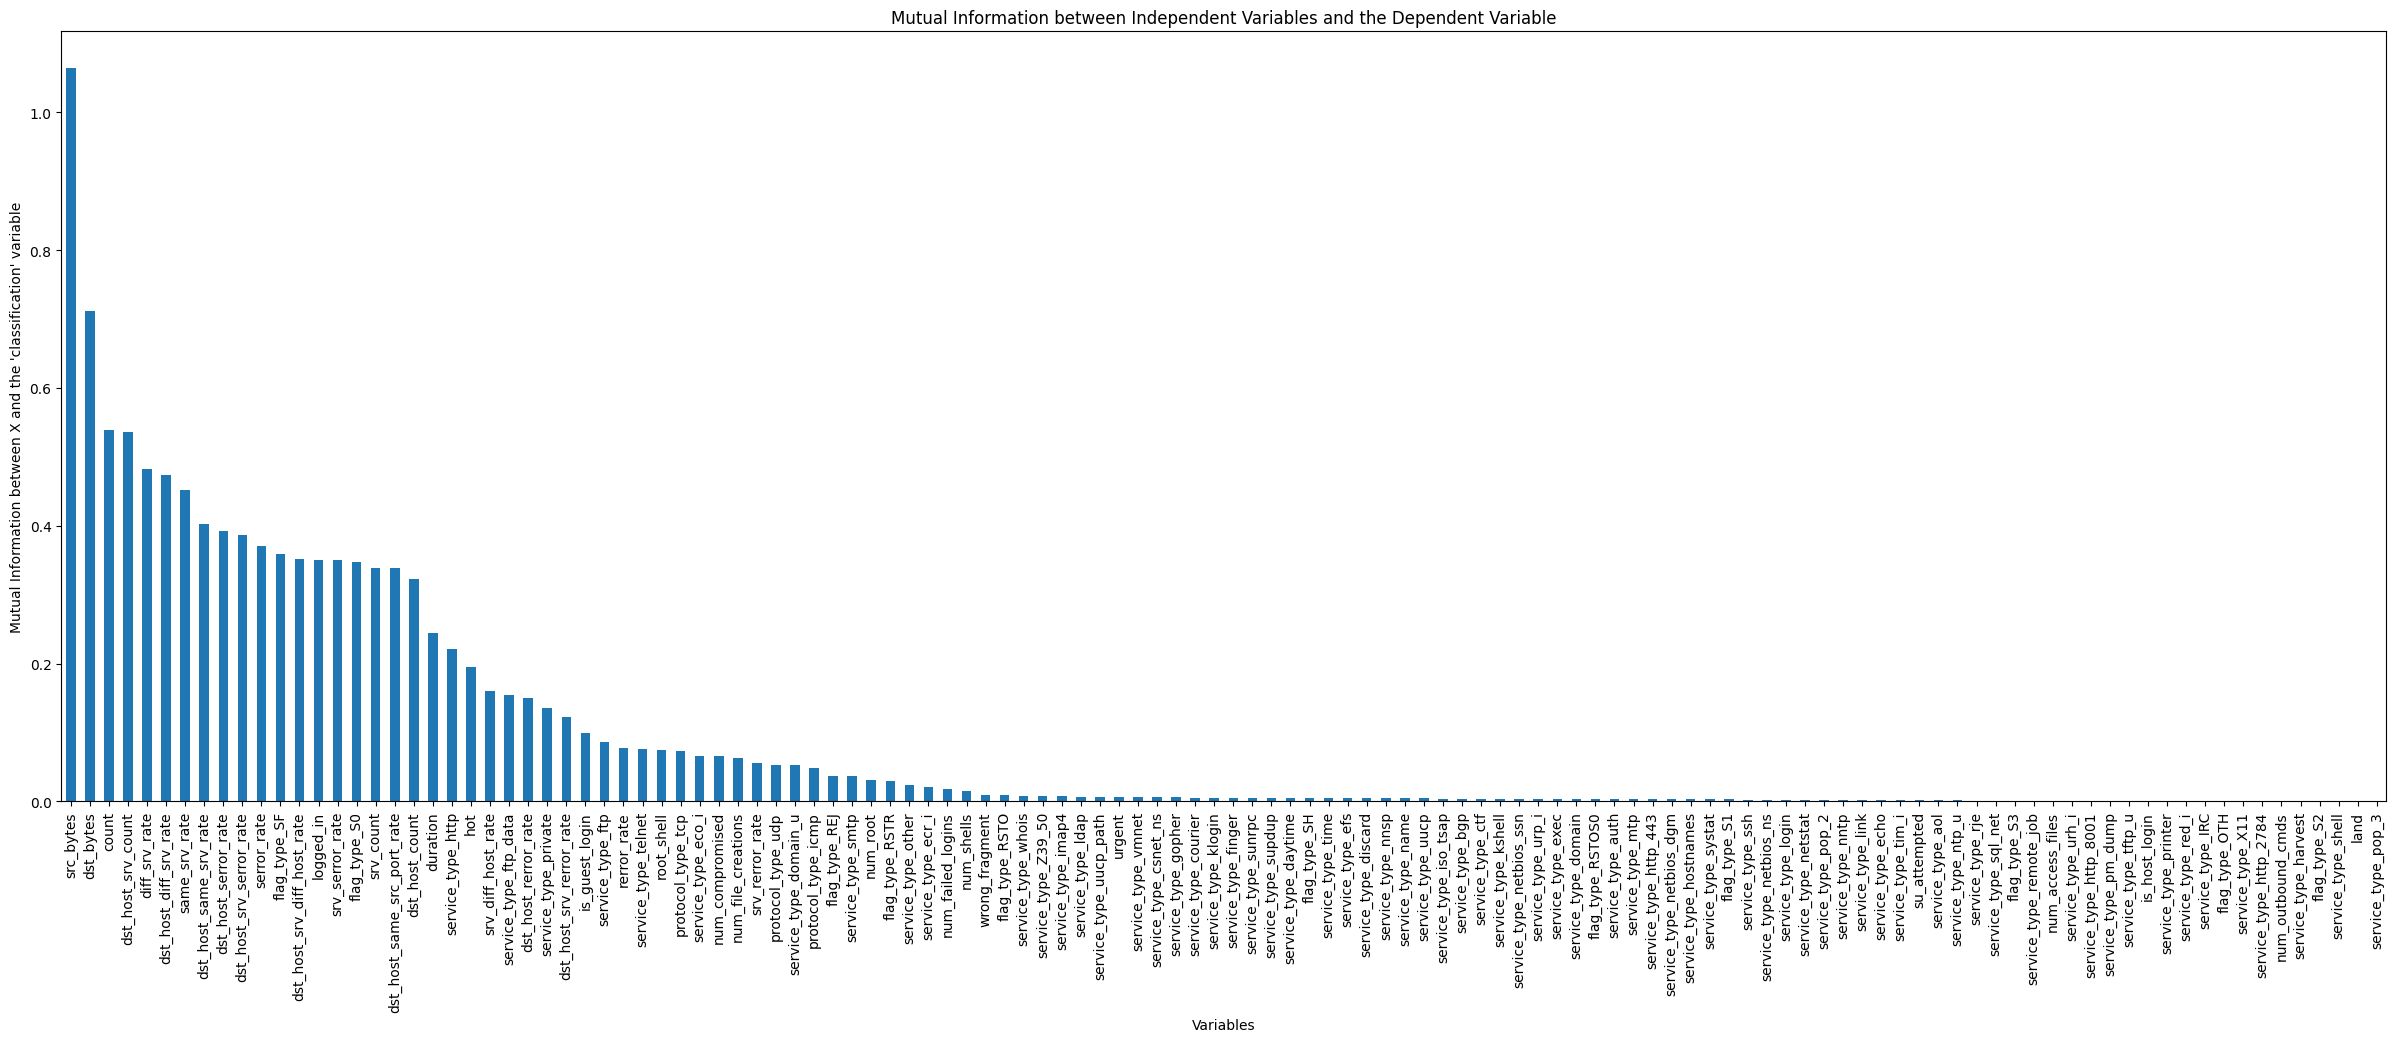

In [25]:
"""---------------------------------- Feature Selection ---------------------------------"""

# Feature Gain - Mutual Information
# Display the plot of variables according to the mutual information gain algorithm
print("Feature Selection ...")
feature_scores = mutual_info_classif(X_train, Y_train)
feature_scores = pd.Series(feature_scores)
feature_scores.index = first_row_train
print("Variables sorted by importance:")
print(feature_scores.sort_values(ascending=False))
plt.figure(figsize=(30, 10))
bar = feature_scores.sort_values(ascending=False).plot(kind="bar")
bar.set_title("Mutual Information between Independent Variables and the Dependent Variable")
bar.set_xlabel("Variables")
bar.set_ylabel("Mutual Information between X and the 'classification' variable")

# Select the top N variables
selection = SelectKBest(mutual_info_classif, k=35)
selection.fit(X_train, Y_train)

print("The variables selected by the information gain algorithm:")
print(X_train.columns[selection.get_support()])